In [12]:
import numpy as np
import scipy.stats as st
import copy
import math
import matplotlib
from matplotlib import pyplot as plt

In [13]:
plt.rcParams.update({'legend.fontsize': 30, 'axes.labelsize' : 30, 'axes.titlesize': 20, 'xtick.labelsize' : 25, 'ytick.labelsize' : 25})

In [14]:
mistake = 10**(-10)
alph = 5
TernConst = 2
GradStep = 10

In [15]:
class Oracle:
    def __init__(self, p, pi):
        assert(p.shape[1] == pi.shape[0])
        self.__pi = copy.copy(pi)
        self.__p = copy.copy(p)
        self.__calc = 0
        self.__grad = 0
        self.__gess = 0
    
    def Calculate(self, x):
        self.__calc += 1
        return np.sum(self.__pi * np.log(self.__p.T @ x))
    
    def CalculateGradient(self, x):
        self.__grad += 1
        return self.__p @ (self.__pi * (self.__p.T @ x)**(-1))
    
    def CalculateGessian(self, x):
        self.__gess += 1
        return -1.0 * self.__p @ np.diagflat(self.__pi * (self.__p.T @ x)**(-2)) @ self.__p.T
    
    @property
    def Calculated(self):
        return self.__calc;
    
    @property
    def CalculatedGradients(self):
        return self.__grad;
    
    @property
    def CalculatedGessians(self):
        return self.__gess;
    
    
class BarierOracle:
    def __init__(self, p, pi, t):
        assert(p.shape[1] == pi.shape[0])
        self.__pi = copy.copy(pi)
        self.__p = copy.copy(p)
        self.__t = t
        self.__calc = 0
        self.__grad = 0
        self.__gess = 0
    
    def Calculate(self, x):
        self.__calc += 1
        return np.sum(self.__pi * np.log(self.__p.T @ x))
    
    def CalculateGradient(self, x):
        self.__grad += 1
        return self.__p @ (self.__pi * (self.__p.T @ x)**(-1)) + self.__t * np.array([1 / xi for xi in x])
    
    def CalculateGessian(self, x):
        self.__gess += 1
        return -1.0 * self.__p @ np.diagflat(self.__pi * (self.__p.T @ x)**(-2)) @ self.__p.T - \
    self.__t * np.diag([1 / xi**2 for xi in x]) 
    
    @property
    def Calculated(self):
        return self.__calc;
    
    @property
    def CalculatedGradients(self):
        return self.__grad;
    
    @property
    def CalculatedGessians(self):
        return self.__gess;

    
class NewtonIterator:
    def __init__(self, begin, oracle, projector, step_choser, priority, checker, normalizator):
        self.__point = copy.copy(begin)
        self.__oracle = copy.copy(oracle)
        self.__projector = copy.copy(projector)
        self.__step_choser = copy.copy(step_choser)
        self.__priority = copy.copy(priority)
        self.__checker = copy.copy(checker)
        self.__normalizator = copy.copy(normalizator)
        self.__step = 1.0
        self.__value = oracle.Calculate(begin)
    def MakeStep(self):
        gess = self.__oracle.CalculateGessian(self.__point)
        grad = self.__oracle.CalculateGradient(self.__point)
        gess = np.linalg.inv(self.__normalizator(gess))
        direction = gess @ self.__projector(grad)
        old_value = self.__value
        improve = False
        while (not improve):
            new_point = self.__point - self.__step * direction
            if (not self.__checker(new_point)):
                self.__step = self.__step_choser(self.__step, False)
            else:
                new_value = self.__oracle.Calculate(new_point)
                improve = self.__priority(new_value, old_value)
                self.__step = self.__step_choser(self.__step, improve)
                if (improve):
                    self.__point = new_point
                    self.__value = new_value
    
    @property
    def Oracle(self):
        return self.__oracle
    
    @property
    def Value(self):
        return self.__value
    
    @property
    def Point(self):
        return self.__point
    
    
def Normalization(A):
    assert(A.shape[0] == A.shape[1])
    return A - np.eye(A.shape[0])
    
def Projector(x):
    y = x - (np.ones(x.size) @ x) * np.ones(x.size) / x.size
    return y
        
def StepChoser(prev, success):
    next = prev
    if success:
        if (next < 1.0):
            next *= 2.0
            if (next > 1):
                next = 1.0
    else:
        next /= 2.0
    return next 

def Checker(x):
    if (not np.all(x > 0)):
        return False
    else:
        return True

def smart_calculation(func, grad, gess, n):
    return n * func + n**2 * grad + n**3 * gess

In [16]:
def _ternarnik(x, y, oracle):
    m1 = x + (y - x) / 3
    m2 = y - (y - x) / 3
    if oracle.Calculate(m1) < oracle.Calculate(m2):
        return (m1, y)
    else:
        return (x, m2)
    
def do_ternar(x, y, oracle):
    for i in range(TernConst):
        (x, y) = _ternarnik(x, y, oracle)
    return (x, y)

def next_grad_point(x_prev, oracle):
    grad = Projector(oracle.CalculateGradient(x_prev))
    t = None
    for (x, g) in zip(x_prev, grad):
        comp = None
        if g < 0:
            comp = -x / g
            if (t == None) or comp < t:
                t = comp
    if t <= GradStep:
        points = do_ternar(x_prev, x_prev + t * 98 / 100 * grad, oracle)
    else:
        points = do_ternar(x_prev, x_prev + GradStep * grad, oracle)
    return((points[0] + points[1]) / 2)

def gradient(begin, p, pi, mistake):
    oracle = Oracle(p, pi)
    n = len(p)
    prev_point = begin
    is_solved = False
    while not is_solved:
        next_point = next_grad_point(prev_point, oracle)
        if np.linalg.norm(next_point - prev_point) < mistake:
            is_solved = True
        prev_point = next_point
    f = oracle.Calculated
    grad = oracle.CalculatedGradients
    gess = oracle.CalculatedGessians
    return (oracle.Calculate(next_point), smart_calculation(f, grad, gess, n), f, grad, gess)

In [17]:
class NewtonSpecializator(NewtonIterator):
    def __init__(self, begin, p, pi):
        priority = lambda x, y: x >= y
        NewtonIterator.__init__(self, begin, Oracle(p, pi), Projector, StepChoser, priority, Checker, Normalization)
        
def newton(begin, p, pi, mistake):
    iterator = NewtonSpecializator(begin, p, pi)
    n = len(p)
    prev = iterator.Value
    finished = False
    while(not finished):
        iterator.MakeStep()
        next = iterator.Value
        finished = (np.abs(next - prev) < mistake)
        prev = next
    f = iterator.Oracle.Calculated
    grad = iterator.Oracle.CalculatedGradients
    gess = iterator.Oracle.CalculatedGessians
    return (iterator.Value, smart_calculation(f, grad, gess, n), f, grad, gess)

In [18]:
class QuasiNewtonIterator:
    def __init__(self, begin, oracle, projector, step_choser, priority, checker, normalizator):
        self.__point = copy.copy(begin)
        self.__oracle = copy.copy(oracle)
        self.__projector = copy.copy(projector)
        self.__step_choser = copy.copy(step_choser)
        self.__priority = copy.copy(priority)
        self.__checker = copy.copy(checker)
        self.__normalizator = copy.copy(normalizator)
        self.__step = 1.0
        self.__value = oracle.Calculate(begin)
        self.__grad = oracle.CalculateGradient(begin)
        self.__C = -np.eye(begin.size)
    def MakeStep(self):
        direction = self.__projector(self.__C @ self.__grad)
        old_value = self.__value
        dpoint = self.__point
        new_point = self.__point - self.__step * direction
        while (not self.__checker(new_point)):
            self.__step = self.__step_choser(self.__step, False)
            new_point = self.__point - self.__step * direction
        new_value = self.__oracle.Calculate(new_point)
        self.__step = self.__step_choser(self.__step, True)
        dpoint = new_point - self.__point
        self.__point = new_point
        self.__value = new_value
        new_grad = self.__oracle.CalculateGradient(self.__point)
        dgrad = new_grad - self.__grad
        self.__grad = new_grad
        dpoint = dpoint.reshape(dpoint.size, 1)
        dgrad = dgrad.reshape(dgrad.size, 1)
        p = 1 / np.sum(dgrad.T @ dpoint)
        prom1 = np.eye(dpoint.size) - p * dpoint @ dgrad.T
        prom2 = np.eye(dpoint.size) - p * dgrad @ dpoint.T
        prom3 = p * dpoint @ dpoint.T
        self.__C = prom1 @ self.__C @ prom2 + prom3
        
    @property
    def Oracle(self):
        return self.__oracle
    
    @property
    def Value(self):
        return self.__value
    
    @property
    def Point(self):
        return self.__point 
        
def PriorityMax(x, y):
    return x > y
    
    
class QuasiNewtonSpecializatorMax(QuasiNewtonIterator):
    def __init__(self, begin, p, pi):
        QuasiNewtonIterator.__init__(self, begin, Oracle(p, pi), Projector, StepChoser, PriorityMax, Checker, Normalization)
        
def quazi_newton(begin, p, pi, mistake):
    iterator = QuasiNewtonSpecializatorMax(begin, p, pi)
    n = len(p)
    prev = iterator.Value
    finished = False
    while(not finished):
        iterator.MakeStep()
        next = iterator.Value
        finished = (np.abs(next - prev) < mistake)
        prev = next
    f = iterator.Oracle.Calculated
    grad = iterator.Oracle.CalculatedGradients
    gess = iterator.Oracle.CalculatedGessians
    return (iterator.Value, smart_calculation(f, grad, gess, n), f, grad, gess)

In [19]:
class BarierNewtonSpecializator(NewtonIterator):
    def __init__(self, begin, p, pi, t):
        priority = lambda x, y: x >= y
        NewtonIterator.__init__(self, begin, BarierOracle(p, pi, t), Projector, StepChoser, priority, Checker, Normalization) 

def FindMaxInnerPoint(begin, p, pi, t, mistake):
    iterator = BarierNewtonSpecializator(begin, p, pi, t)
    prev = iterator.Value
    finished = False
    while(not finished):
        iterator.MakeStep()
        next = iterator.Value
        finished = (np.abs(next - prev) < mistake)
        prev = next
    return iterator

def inner_point(begin, p, pi, mistake):
    real_oracle = Oracle(p, pi)
    n = len(p)
    t = 1
    m = len(begin)
    f = 0
    grad = 0
    gess = 0
    iterator = BarierNewtonSpecializator(begin, p, pi, t)
    finished = False
    while(not finished):
        iterator = FindMaxInnerPoint(iterator.Point, p, pi, t, m * t)
        f += iterator.Oracle.Calculated
        grad += iterator.Oracle.CalculatedGradients
        gess += iterator.Oracle.CalculatedGessians
        finished = (m * t < mistake)
        t /= alph
    return (real_oracle.Calculate(iterator.Point), smart_calculation(f, grad, gess, n), f, grad, gess)

In [20]:
methods_config = {
    "methods": [gradient, newton, quazi_newton, inner_point],
    "names": ["Gradient", "Newton", "QuaziNewton", "InnerPoint"],
    "colors": ["orange", "blue", "red", "brown"]
}

In [21]:
def Compare(methods_config):
    m = 30
    methods_results = [[] for _ in methods_config["methods"]]
    
    for n in range(2, 20):
        x0 = np.ones(n) / n
        x1 = x0 + np.array([1/2/n] + [-1 / 2 / n / (n - 1)] * (n - 1))
        x2 = x0 + np.array([-1 / 2 / n / (n - 1)] * (n - 1) + [1/2/n])
        xs = (x1, x2)
        
        p = np.abs(np.random.rand(n, m) * 3 + 5)
        pi = np.abs(np.random.rand(m))
        pi /= np.sum(pi)
        
        for (method, results) in zip(methods_config["methods"], methods_results):
            result = method(x0, p, pi, mistake)
            for x in xs:
                r =  method(x, p, pi, mistake)
                if (r[0] > result[0]):
                    result = r
            results.append(result)
    return methods_results

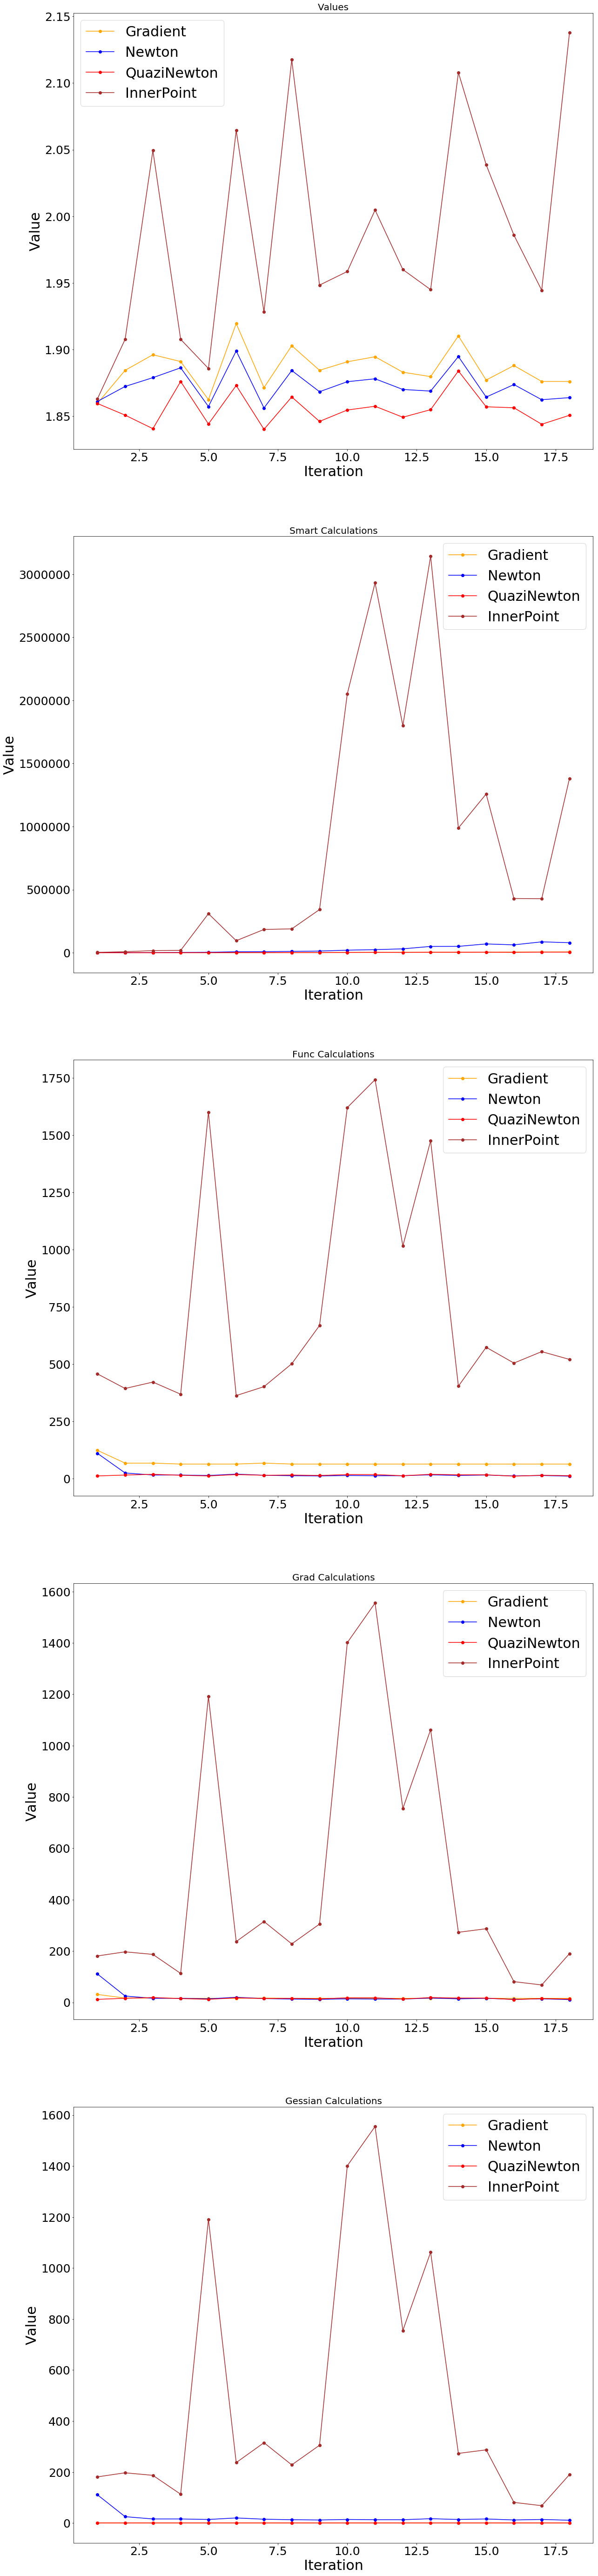

In [22]:
methods_results = Compare(methods_config)
n = len(methods_results[0])
X = np.arange(n) + 1
fig, axes = plt.subplots(nrows=5,figsize=(20, 20 * 5))
for (i, name, ax) in zip(range(5),
                         ("Values", "Smart Calculations", "Func Calculations", "Grad Calculations", "Gessian Calculations"),
                         axes):
    ax.set_title(name) 
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Value")
    for (method_name, color, results) in zip(methods_config["names"], methods_config["colors"], methods_results):
        ax.plot(X, [res[i] for res in results], '-o', label=method_name, color=color)
    ax.legend()